In [1]:
import os
import random
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.utils as vutils


random.seed(999)
torch.manual_seed(999)
torch.use_deterministic_algorithms(False)

In [2]:
path = "data/mnist_data"

WORKERS = 2

BATCH_SIZE = 256

IMAGE_SIZE = 64

# Input Channels
n_channels = 1

# Latent Vector Size --> n-dimensional space from where random inputs are drawn from for the Generator
n_z = 16

# Number of Feature Maps/Channels for Generator
ngf = 64

# Number of Feature Maps/Channels for Discriminator
ngd = 64

# Learning rate for optimizers
lr = [0.0001, 0.001, 0.01, 0.1]

# Beta 1 value for the Adam optimizer --> Controls how much of the previous running averages (1st Moment) are kept in current calculation
b1 = 0

# Beta 2 value for the Adam optimizer --> Controls how much of the squared previous running averages (2nd Moment) are kept in current calculation
b2 = 0.9

# Training Epochs
epochs = 5

# Number of times Discriminator's loss calculation is taken per iter
n_critic = 5

# Number of iterations per epoch
n_iters = 10000

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

dataset = datasets.MNIST(
    root=path,
    train=True,
    download=True,
    transform=transform
)

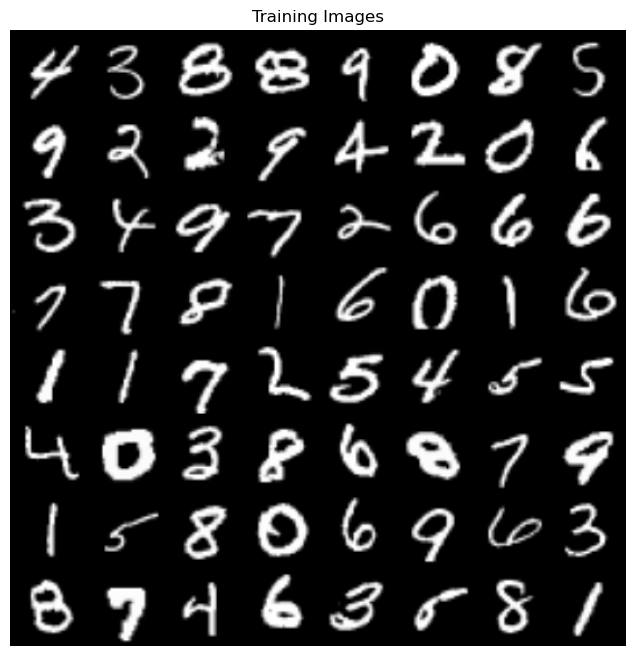

In [5]:
dataloader = DataLoader(
    dataset=dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=WORKERS
)


real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

### Defining the Generator Class and Model Architecture

In [6]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(in_channels=n_z, out_channels=512, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(True),

            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(True),

            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(True),

            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(True),

            # Final out_channel is still 3 because the grayscale mnist images are represented using 3-channels (i.e same rgb values for all channels)
            nn.ConvTranspose2d(in_channels=64, out_channels=1, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    # Forward Loop of the Generator
    def forward(self, input):
        return self.model(input)

### Defining the Discriminator Class and Model Architecture

In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, True),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_features=128),
            nn.LeakyReLU(0.2, True),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_features=256),
            nn.LeakyReLU(0.2, True),

            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_features=512),
            nn.LeakyReLU(0.2, True),

            nn.Conv2d(in_channels=512, out_channels=1, kernel_size=4, stride=1, padding=0),
        )

    def forward(self, input):
        rtn = self.model(input)
        return torch.flatten(rtn)

In [8]:
# Instantiating Generator
G = Generator()
G.to(device)

Generator(
  (model): Sequential(
    (0): ConvTranspose2d(16, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (13): Tanh()
  )
)

In [9]:
# Instantiating Discriminator
D = Discriminator()
D.to(device)

Discriminator(
  (model): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1))
  )
)

In [10]:
# Initializing Optimizers to Use

optim_D = torch.optim.Adam(D.parameters(), lr=lr[0], betas=(b1, b2))
optim_G = torch.optim.Adam(G.parameters(), lr=lr[0], betas=(b1, b2))

D.train()

Discriminator(
  (model): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1))
  )
)

### Training Loop

In [11]:
###################################################################
# Gradient Penalty Calculation for the Wasserstein Loss Calculation
###################################################################

def calculate_gradient_penalty(model, real_images, fake_images, device):
    # Random weight term for interpolation between real and fake data
    alpha = torch.randn((real_images.size(0), 1, 1, 1), device=device)
    # Get random interpolation between real and fake data
    interpolates = (alpha * real_images + ((1 - alpha) * fake_images)).requires_grad_(True)

    model_interpolates = model(interpolates)
    grad_outputs = torch.ones(model_interpolates.size(), device=device, requires_grad=False)

    # Get gradient w.r.t. interpolates
    gradients = torch.autograd.grad(
        outputs=model_interpolates,
        inputs=interpolates,
        grad_outputs=grad_outputs,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = torch.mean((gradients.norm(2, dim=1) - 1) ** 2)
    return gradient_penalty

In [13]:
##############################################
# Start of Training Loop
##############################################

img_list = []
G_losses = []
D_losses = []

D.train()
G.train()

# Start train PSNR model.
print(f"Training for {epochs} epochs")

fixed_noise = torch.randn(BATCH_SIZE, n_z, 1, 1, device=device)

for epoch in range(0, epochs):
    progress_bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for i, data in progress_bar:
        real_images = data[0].to(device)
        batch_size = real_images.size(0)
        noise = torch.randn(batch_size, n_z, 1, 1, device=device)

        ##############################################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ##############################################
        # Set discriminator gradients to zero.
        D.zero_grad()

        # Train with real
        real_output = D(real_images)
        errD_real = torch.mean(real_output)
        D_x = real_output.mean().item()

        # Generate fake image batch with G
        fake_images = G(noise)

        # Train with fake
        fake_output = D(fake_images.detach())
        errD_fake = torch.mean(fake_output)
        D_G_z1 = fake_output.mean().item()
        
        # Calculate W-div gradient penalty
        gradient_penalty = calculate_gradient_penalty(model=D, real_images=real_images.data, fake_images=fake_images.data, device=device)

        # Add the gradients from the all-real and all-fake batches
        errD = -errD_real + errD_fake + gradient_penalty * 10
        errD.backward()
        # Update D
        optim_D.step()

        # Train the generator every n_critic iterations
        if (i + 1) % n_critic == 0:
            ##############################################
            # (2) Update G network: maximize log(D(G(z)))
            ##############################################
            # Set generator gradients to zero
            G.zero_grad()

            # Generate fake image batch with G
            fake_images = G(noise)
            fake_output = D(fake_images)
            errG = -torch.mean(fake_output)
            D_G_z2 = fake_output.mean().item()
            errG.backward()
            optim_G.step()

            progress_bar.set_description(f"[{epoch + 1}/{epochs}][{i + 1}/{len(dataloader)}] "
                                            f"Loss_D: {errD.item():.6f} Loss_G: {errG.item():.6f} "
                                            f"D(x): {D_x:.6f} D(G(z)): {D_G_z1:.6f}/{D_G_z2:.6f}")

            G_losses.append(errG.item())
            D_losses.append(errD.item())

        iters = i + epoch * len(dataloader) + 1

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 250 == 0) or ((epoch == epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = G(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        if iters == int(n_iters):  # If the iteration is reached, exit.
            break

Training for 5 epochs


[1/5][235/235] Loss_D: -270.619629 Loss_G: 134.014130 D(x): 137.962463 D(G(z)): -133.553650/-134.014130: 100%|██████████| 235/235 [00:41<00:00,  5.66it/s]
[2/5][235/235] Loss_D: -518.628479 Loss_G: 256.873901 D(x): 262.430267 D(G(z)): -256.351898/-256.873901: 100%|██████████| 235/235 [00:44<00:00,  5.30it/s]
[3/5][235/235] Loss_D: -776.421997 Loss_G: 389.442139 D(x): 392.483154 D(G(z)): -384.969452/-389.442139: 100%|██████████| 235/235 [00:43<00:00,  5.44it/s]
[4/5][235/235] Loss_D: -864.792114 Loss_G: 519.345825 D(x): 507.992554 D(G(z)): -444.153412/-519.345825: 100%|██████████| 235/235 [00:44<00:00,  5.24it/s] 
[5/5][235/235] Loss_D: -1307.934204 Loss_G: 673.330811 D(x): 674.801941 D(G(z)): -635.122009/-673.330811: 100%|██████████| 235/235 [00:47<00:00,  4.93it/s]


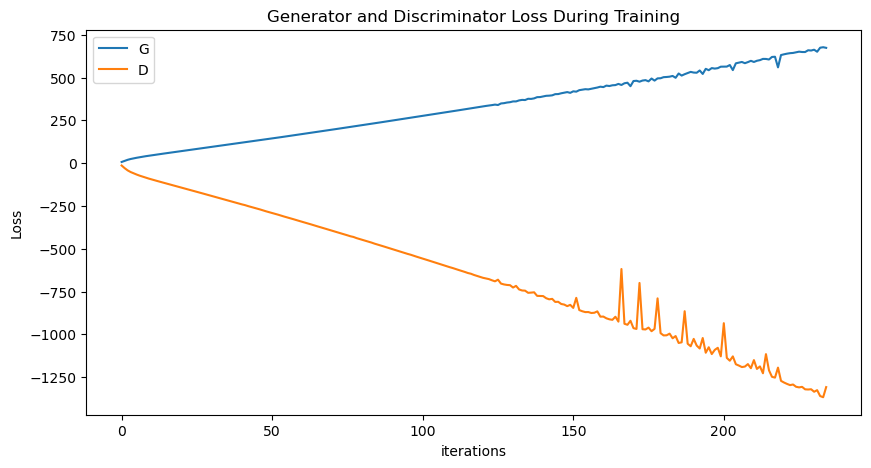

In [14]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

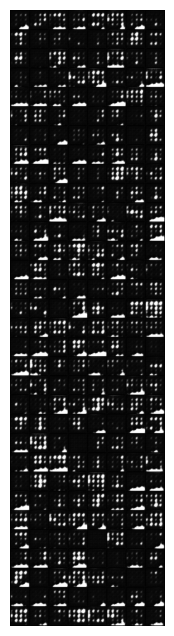

In [15]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

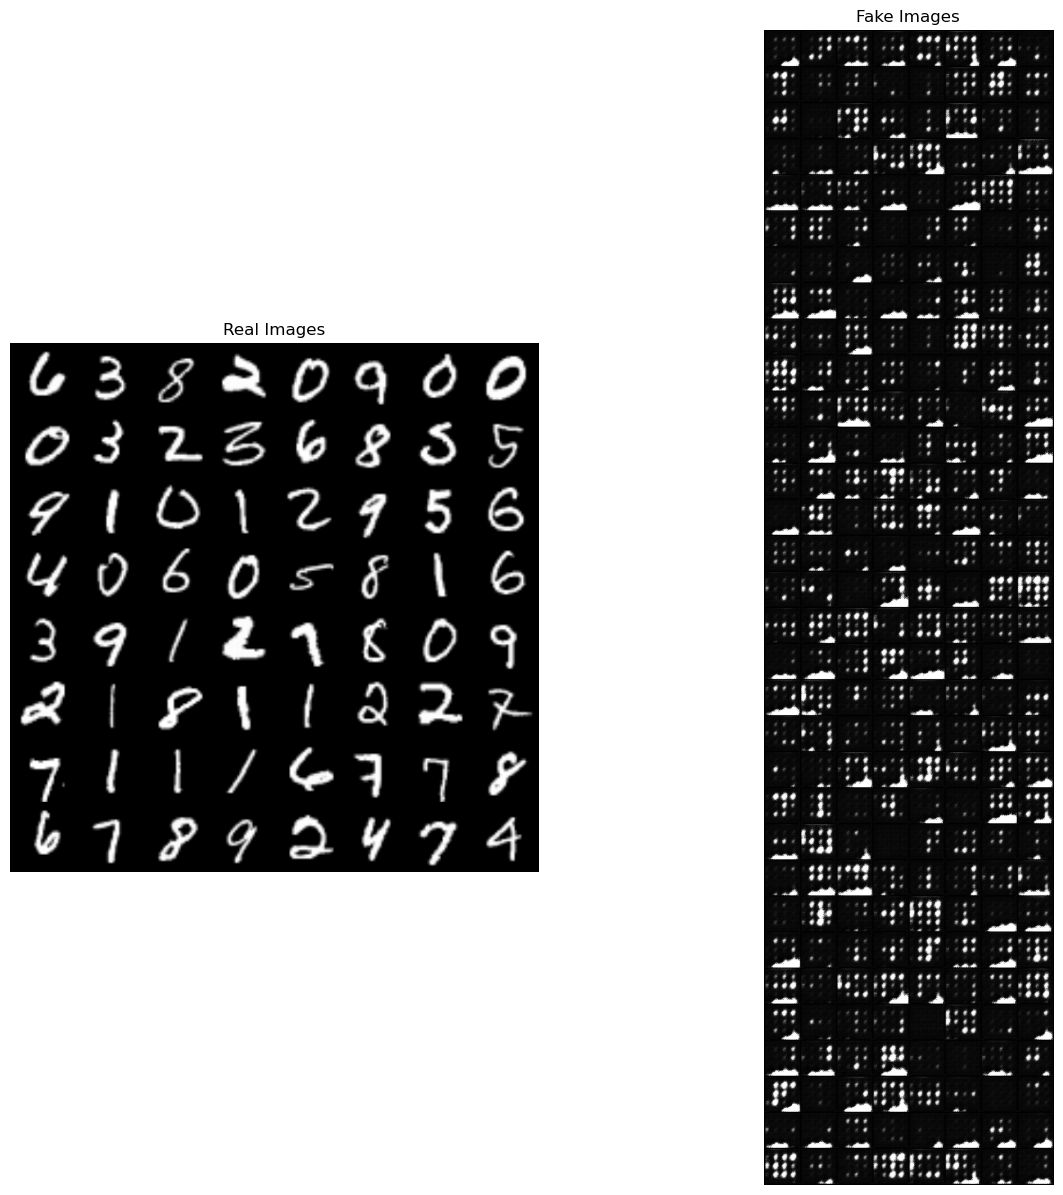

In [16]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()